In [1]:
!pip install mindspore numpy==1.23.5 download



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.0/962.0 MB 844.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
numba 0.6

In [1]:
from download import download

url = "https://mindspore-website.obs.cn-north-4.myhuaweicloud.com/notebook/datasets/cifar-10-binary.tar.gz"

download(url, "./datasets-cifar10-bin", kind="tar.gz", replace=True)


file_sizes: 100%|████████████████████████████| 170M/170M [00:13<00:00, 12.3MB/s]
Extracting tar.gz file...
Successfully downloaded / unzipped to ./datasets-cifar10-bin


'./datasets-cifar10-bin'

In [11]:
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
import os
import mindspore.dataset.transforms as transforms
from mindspore import dtype as mstype
import mindspore as ms

# Set MindSpore to use CPU explicitly
context.set_context(mode=context.GRAPH_MODE, device_target="CPU")
data_dir = "/content/datasets-cifar10-bin/cifar-10-batches-bin"  # Root directory of the dataset
batch_size = 256  # Batch size
image_size = 224  # Image size of training data
# workers = 4  # Number of parallel workers
num_classes = 10  # Number of classes


workers = min(8, os.cpu_count())
def create_dataset_cifar10(dataset_dir, usage, resize, batch_size, workers):

    data_set = ds.Cifar10Dataset(dataset_dir=dataset_dir,
                                 usage=usage,
                                 num_parallel_workers=workers,
                                 shuffle=True)

    trans = []
    if usage == "train":
        trans += [
            vision.RandomCrop((32, 32), (4, 4, 4, 4)),
            vision.RandomHorizontalFlip(prob=0.5)
        ]

    trans += [
        vision.Resize(resize),
        vision.Rescale(1.0 / 255.0, 0.0),
        vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        vision.HWC2CHW()
    ]

    target_trans = transforms.TypeCast(mstype.int32)

    # Data transformation
    data_set = data_set.map(operations=trans,
                            input_columns='image',
                            num_parallel_workers=workers)

    data_set = data_set.map(operations=target_trans,
                            input_columns='label',
                            num_parallel_workers=workers)

    # Batching
    data_set = data_set.batch(batch_size)

    return data_set


# Obtain the preprocessed training and testing datasets

dataset_train = create_dataset_cifar10(dataset_dir=data_dir,
                                       usage="train",
                                       resize=image_size,
                                       batch_size=batch_size,
                                       workers=workers)
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_cifar10(dataset_dir=data_dir,
                                     usage="test",
                                     resize=image_size,
                                     batch_size=batch_size,
                                     workers=workers)
step_size_val = dataset_val.get_dataset_size()


[WARNING] ME(6173:140021009707648,MainProcess):2025-03-19-00:05:21.630.000 [mindspore/context.py:1335] For 'context.set_context', the parameter 'device_target' will be deprecated and removed in a future version. Please use the api mindspore.set_device() instead.


In [12]:
dataset_train

In [13]:
from mindspore import nn, Tensor,load_checkpoint, load_param_into_net


class ResNet(nn.Cell):
    def __init__(self,num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=1, pad_mode='pad')
        self.max_pool = nn.MaxPool2d(kernel_size=3, stride=2, pad_mode='same')
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(64, 128, kernel_size=7, stride=2, padding=1, pad_mode='pad')
        self.flatten = nn.Flatten()
        self.fc = nn.Dense(in_channels=128*26*26, out_channels=num_classes)

    def construct(self, x):

        x = self.conv1(x)
        x = self.relu(x)
        x = self.max_pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)

        return x


In [ ]:
import mindspore as ms
import mindspore.nn as nn
from mindspore import Tensor, context
from mindspore.train import Model
from mindspore.train.callback import LossMonitor
import mindspore.ops as ops


dataset_train = create_dataset_cifar10(dataset_dir=data_dir,
                                       usage="train",
                                       resize=image_size,
                                       batch_size=batch_size,
                                       workers=workers)

net = ResNet(num_classes=10)
# num_epochs = 5
# Define optimizer and loss function
opt = nn.Adam(net.trainable_params(), learning_rate=0.001)
loss_fn = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')


# Create model
model = Model(net, loss_fn=loss_fn, optimizer=opt, metrics={'accuracy'})


# Train model
print("===== Starting Training =====")
model.train(1, dataset_train, dataset_sink_mode=False)

===== Starting Training =====


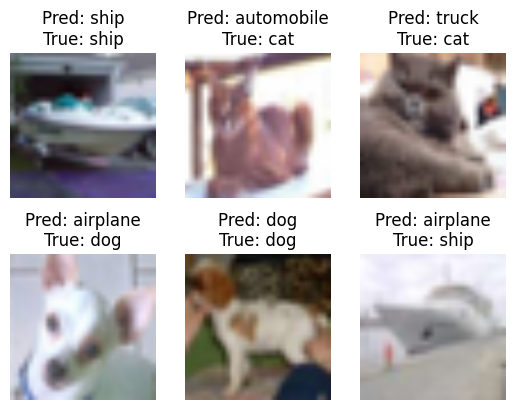

In [ ]:
# Test model on a few images
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of test data
data_iter = next(dataset_val.create_dict_iterator())
images = data_iter["image"].asnumpy()
labels = data_iter["label"].asnumpy()

# Predict
outputs = model.predict(Tensor(data_iter["image"]))
predictions = np.argmax(outputs.asnumpy(), axis=1)

# Class names for CIFAR-10
classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Show 5 test images with predictions
plt.figure()
for i in range(6):
    plt.subplot(2, 3, i + 1)
    image_trans = np.transpose(images[i], (1, 2, 0))
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    image_trans = std * image_trans + mean
    image_trans = np.clip(image_trans, 0, 1)
    plt.title(f"Pred: {classes[predictions[i]]}\nTrue: {classes[labels[i]]}")
    plt.imshow(image_trans)
    plt.axis("off")
plt.show()


# plt.figure()
# for i in range(6):
#     plt.subplot(2, 3, i + 1)
#     image_trans = np.transpose(images[i], (1, 2, 0))
#     mean = np.array([0.4914, 0.4822, 0.4465])
#     std = np.array([0.2023, 0.1994, 0.2010])
#     image_trans = std * image_trans + mean
#     image_trans = np.clip(image_trans, 0, 1)
#     plt.title(f"Pred: {classes[predictions[i]]}\nTrue: {classes[labels[i]]}")
#     plt.imshow(image_trans)
#     plt.axis("off")
# plt.show()